# Is Warren Buffet's Portfolio Choice Optimal?

## 1. Introduction

Warren Buffet is the world's most prominent value investor. We decided to analyze his portfolio to see if there were any improvements to be made. We make use of the work of:
- Michael Pinelis and David Ruppert (Machine learning portfolio allocation(2021))
-  Shihao Gu, Bryan Kelly, and Dacheng Xiu (Empirical Asset Pricing via Machine
 Learning(2019))

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno 
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, PowerTransformer, QuantileTransformer
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SelectFromModel
import base64
from IPython.display import Image, display
from sklearn.model_selection import RandomizedSearchCV

In [20]:
BuffetPortfolioOverview = pd.read_csv("Warren Buffet Portfolio Overview.csv")
BuffetPortfolioOverview

,Company,Ticker,"Market value as of 31 March, 2024",Number of shares,% of total portfolio
0,APPLE INC (COM),AAPL,"135,360,902,000","789,368,450",40.81%
1,BANK OF AMERICA CORP (COM),BAC,"39,165,748,000","1,032,852,006",11.81%
2,AMERICAN EXPRESS CO (COM),AXP,"34,520,240,000","151,610,700",10.41%
3,COCA COLA CO (COM),KO,"24,472,000,000","400,000,000",7.38%
4,CHEVRON CORP (COM),CVX,"19,398,898,000","122,980,207",5.85%
5,OCCIDENTAL PETROLEUM (COM),OXY,"16,118,698,000","248,018,128",4.86%
6,KRAFT HEINZ CO (COM),KHC,"12,015,925,000","325,634,818",3.62%
7,MOODYS CORP (COM),MCO,"9,695,962,000","24,669,778",2.92%
8,CHUBB LIMITED (COM),CB,"6,717,645,000","25,923,840",2.03%
9,DAVITA HEALTHCARE PARTNERS (COM),DVA,"4,982,993,000","36,095,570",1.50%


## 2. Research Method

In [21]:
def mm(graph):
    graphbytes = graph.encode("utf8")
    base64_bytes = base64.b64encode(graphbytes)
    base64_string = base64_bytes.decode("ascii")
    display(Image(url="https://mermaid.ink/img/" + base64_string))

mm("""
graph TD
    subgraph "Data Processing"
        A[Raw Data] --> B[Missing Value Imputation]
        B --> C[Normalization]
    end

    subgraph "Feature Engineering"
        D[Features] --> E[Fundamental Features]
        D --> F[Technical Features]
        D --> G[Sentiment Features]
    end
    
    E --> H[RF Model Training]
    F --> H
    G --> H
		
    subgraph "Training"
        H[RF Model Training] --> I[Hyperparameter Optimization]
        I --> J[Optimal Model]
    end

    subgraph "Prediction"
        K[Test Data] --> L[Return Ratio Prediction]
    end

    subgraph "Investment Strategy"
        M[Investment Strategy] --> N[Stock Selection]
        N --> O[Investment Portfolio Return & Std]
    end

    subgraph "Evaluation"
        P[Evaluation Method] --> Q[Sharpe Ratio]
    end

    C --> D
    J --> L
    L --> N
    O --> Q
""")

## 3. Data Processing

In [25]:
financial_ratios = pd.read_csv("2014-2024 Buffet Portfolio - financial ratios.csv")
financial_ratios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4711 entries, 0 to 4710
Data columns (total 76 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   gvkey            4711 non-null   int64  
 1   permno           4711 non-null   int64  
 2   adate            4701 non-null   object 
 3   qdate            4711 non-null   object 
 4   public_date      4711 non-null   object 
 5   CAPEI            4642 non-null   float64
 6   bm               4397 non-null   float64
 7   evm              4701 non-null   float64
 8   pe_op_basic      4640 non-null   float64
 9   pe_op_dil        4640 non-null   float64
 10  pe_exi           4640 non-null   float64
 11  pe_inc           4640 non-null   float64
 12  ps               4701 non-null   float64
 13  pcf              4680 non-null   float64
 14  dpr              4234 non-null   float64
 15  npm              4701 non-null   float64
 16  opmbd            4701 non-null   float64
 17  opmad         

In [26]:
stock = pd.read_csv("2014-2024 Buffet Portfolio - stock.csv")
stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89589 entries, 0 to 89588
Data columns (total 63 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   PERMNO    89589 non-null  int64  
 1   date      89589 non-null  object 
 2   NAMEENDT  127 non-null    object 
 3   SHRCD     89589 non-null  int64  
 4   EXCHCD    89589 non-null  int64  
 5   SICCD     89589 non-null  object 
 6   NCUSIP    89589 non-null  object 
 7   TICKER    89589 non-null  object 
 8   COMNAM    89589 non-null  object 
 9   SHRCLS    24210 non-null  object 
 10  TSYMBOL   89589 non-null  object 
 11  NAICS     89563 non-null  float64
 12  PRIMEXCH  89589 non-null  object 
 13  TRDSTAT   89589 non-null  object 
 14  SECSTAT   89589 non-null  object 
 15  PERMCO    89589 non-null  int64  
 16  ISSUNO    89589 non-null  int64  
 17  HEXCD     89589 non-null  int64  
 18  HSICCD    89589 non-null  int64  
 19  CUSIP     89589 non-null  object 
 20  DCLRDT    931 non-null    ob

/tmp/ipykernel_48310/2572745106.py:1: DtypeWarning: Columns (5,9,22,49,57) have mixed types. Specify dtype option on import or set low_memory=False.
  stock = pd.read_csv("2014-2024 Buffet Portfolio - stock.csv")


In [24]:
merged_data = pd.read_csv("merged_financial_stock_macro_data.csv")
merged_data = merged_data.drop(merged_data.columns[0], axis=1)
merged_data.head()

,TICKER,date,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,...,TICKER_encoded,SHRCD_encoded,EXCHCD_encoded,SICCD_encoded,market_cap,RET_calc,RET_interp,TB3MS,T10Y2Y,BAA10Y
0,AAPL,2014-01-31,17.588,0.327,7.993,12.506,12.594,12.594,12.594,2.613,...,0.0,0.0,1.0,10.0,4.465297e+08,0.001637,0.001637,0.04,2.464286,2.334762
1,AAPL,2014-02-28,18.776,0.296,7.764,0.463,0.466,0.466,0.466,2.698,...,0.0,0.0,1.0,10.0,4.694003e+08,-0.002710,-0.002710,0.05,2.382632,2.390000
2,AAPL,2014-03-31,18.501,0.296,7.764,0.472,0.475,0.475,0.475,2.658,...,0.0,0.0,1.0,10.0,4.625330e+08,-0.000224,-0.000224,0.05,2.324286,2.340952
3,AAPL,2014-04-30,20.332,0.296,7.764,0.519,0.523,0.523,0.523,2.921,...,0.0,0.0,1.0,10.0,5.082923e+08,-0.003782,-0.003782,0.03,2.288095,2.199048
4,AAPL,2014-05-31,20.513,0.302,7.873,0.537,0.540,0.540,0.540,3.097,...,0.0,0.0,1.0,10.0,5.452542e+08,-0.003746,-0.003746,0.03,2.170000,2.203810


# 4. Descriptive Analysis

In [34]:
print(merged_data.RET.dtype)

float64


/home/onlyartist9/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/onlyartist9/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


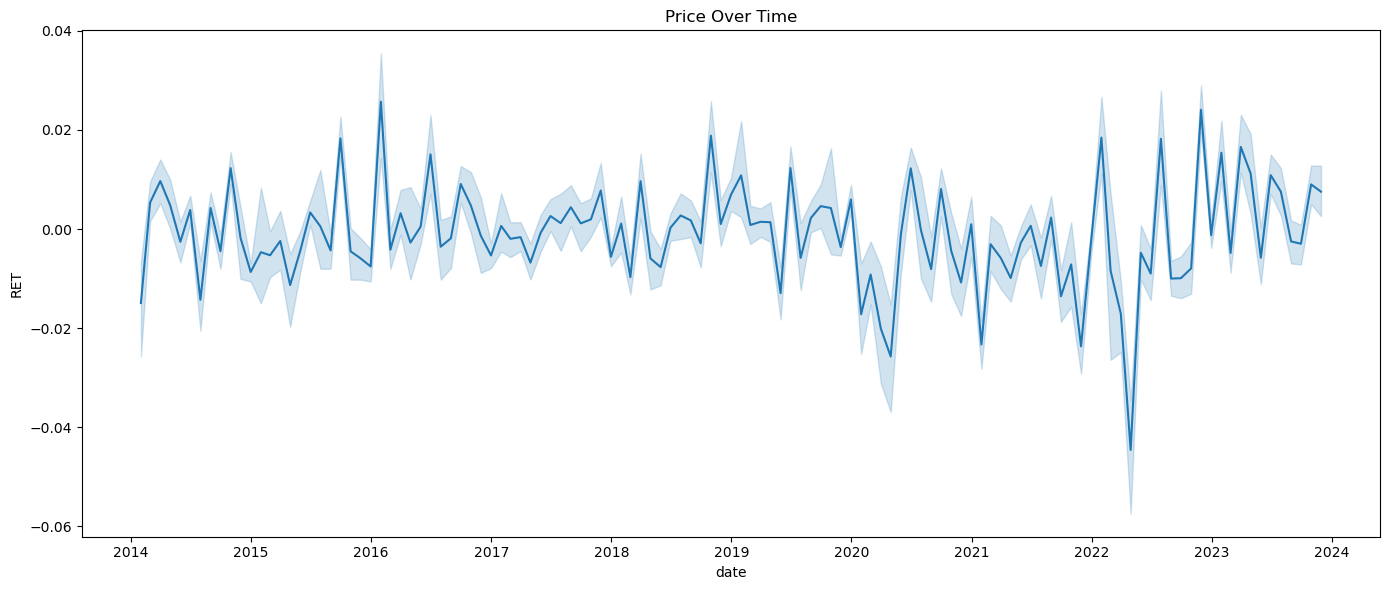

In [37]:
merged_data['date'] = pd.to_datetime(merged_data['date'])

# Basic statistical description
statistical_description = merged_data.describe()

# Plotting the trends of a few selected metrics over time
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(14, 6))

# Plotting RET
sns.lineplot(x='date', y='RET', data=merged_data).set_title('Price Over Time')

plt.tight_layout()
plt.show()

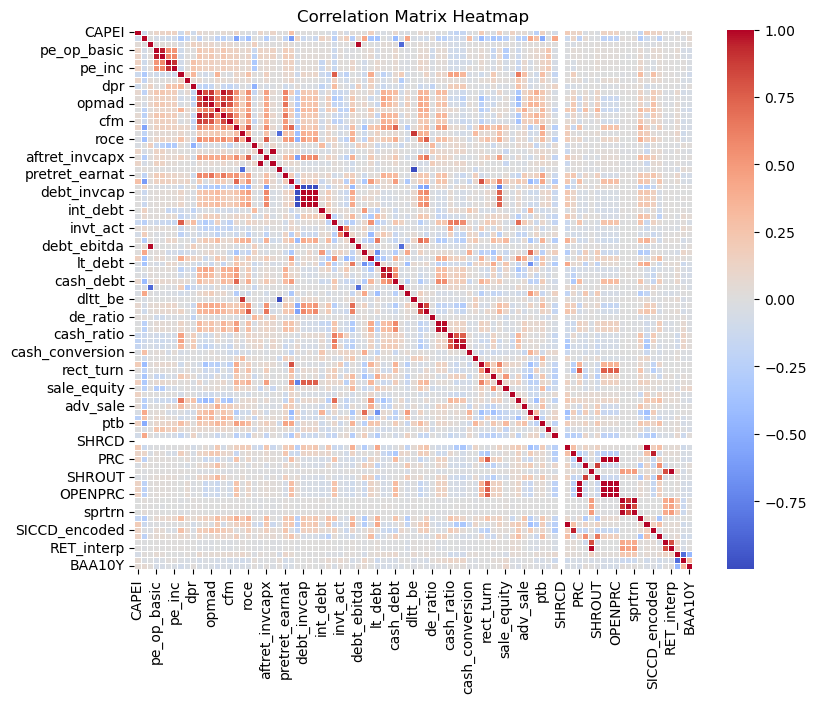

<Figure size 640x480 with 0 Axes>

In [38]:
# Recalculate the correlation matrix
correlation_matrix = merged_data.select_dtypes(include=['number']).drop(columns = 'SHRCD_encoded').corr()

# Set up the matplotlib figure
plt.figure(figsize=(9, 7))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, annot=False, fmt=".1f", linewidths=.5, cmap="coolwarm")
plt.title('Correlation Matrix Heatmap')
plt.show()
plt.savefig('Correlation_matrix_heatmap.png')


/tmp/ipykernel_48310/2893394758.py:12: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  numeric_data.hist(layout=(-1, 3), bins=np.linspace(-1,1,50), ax=ax)


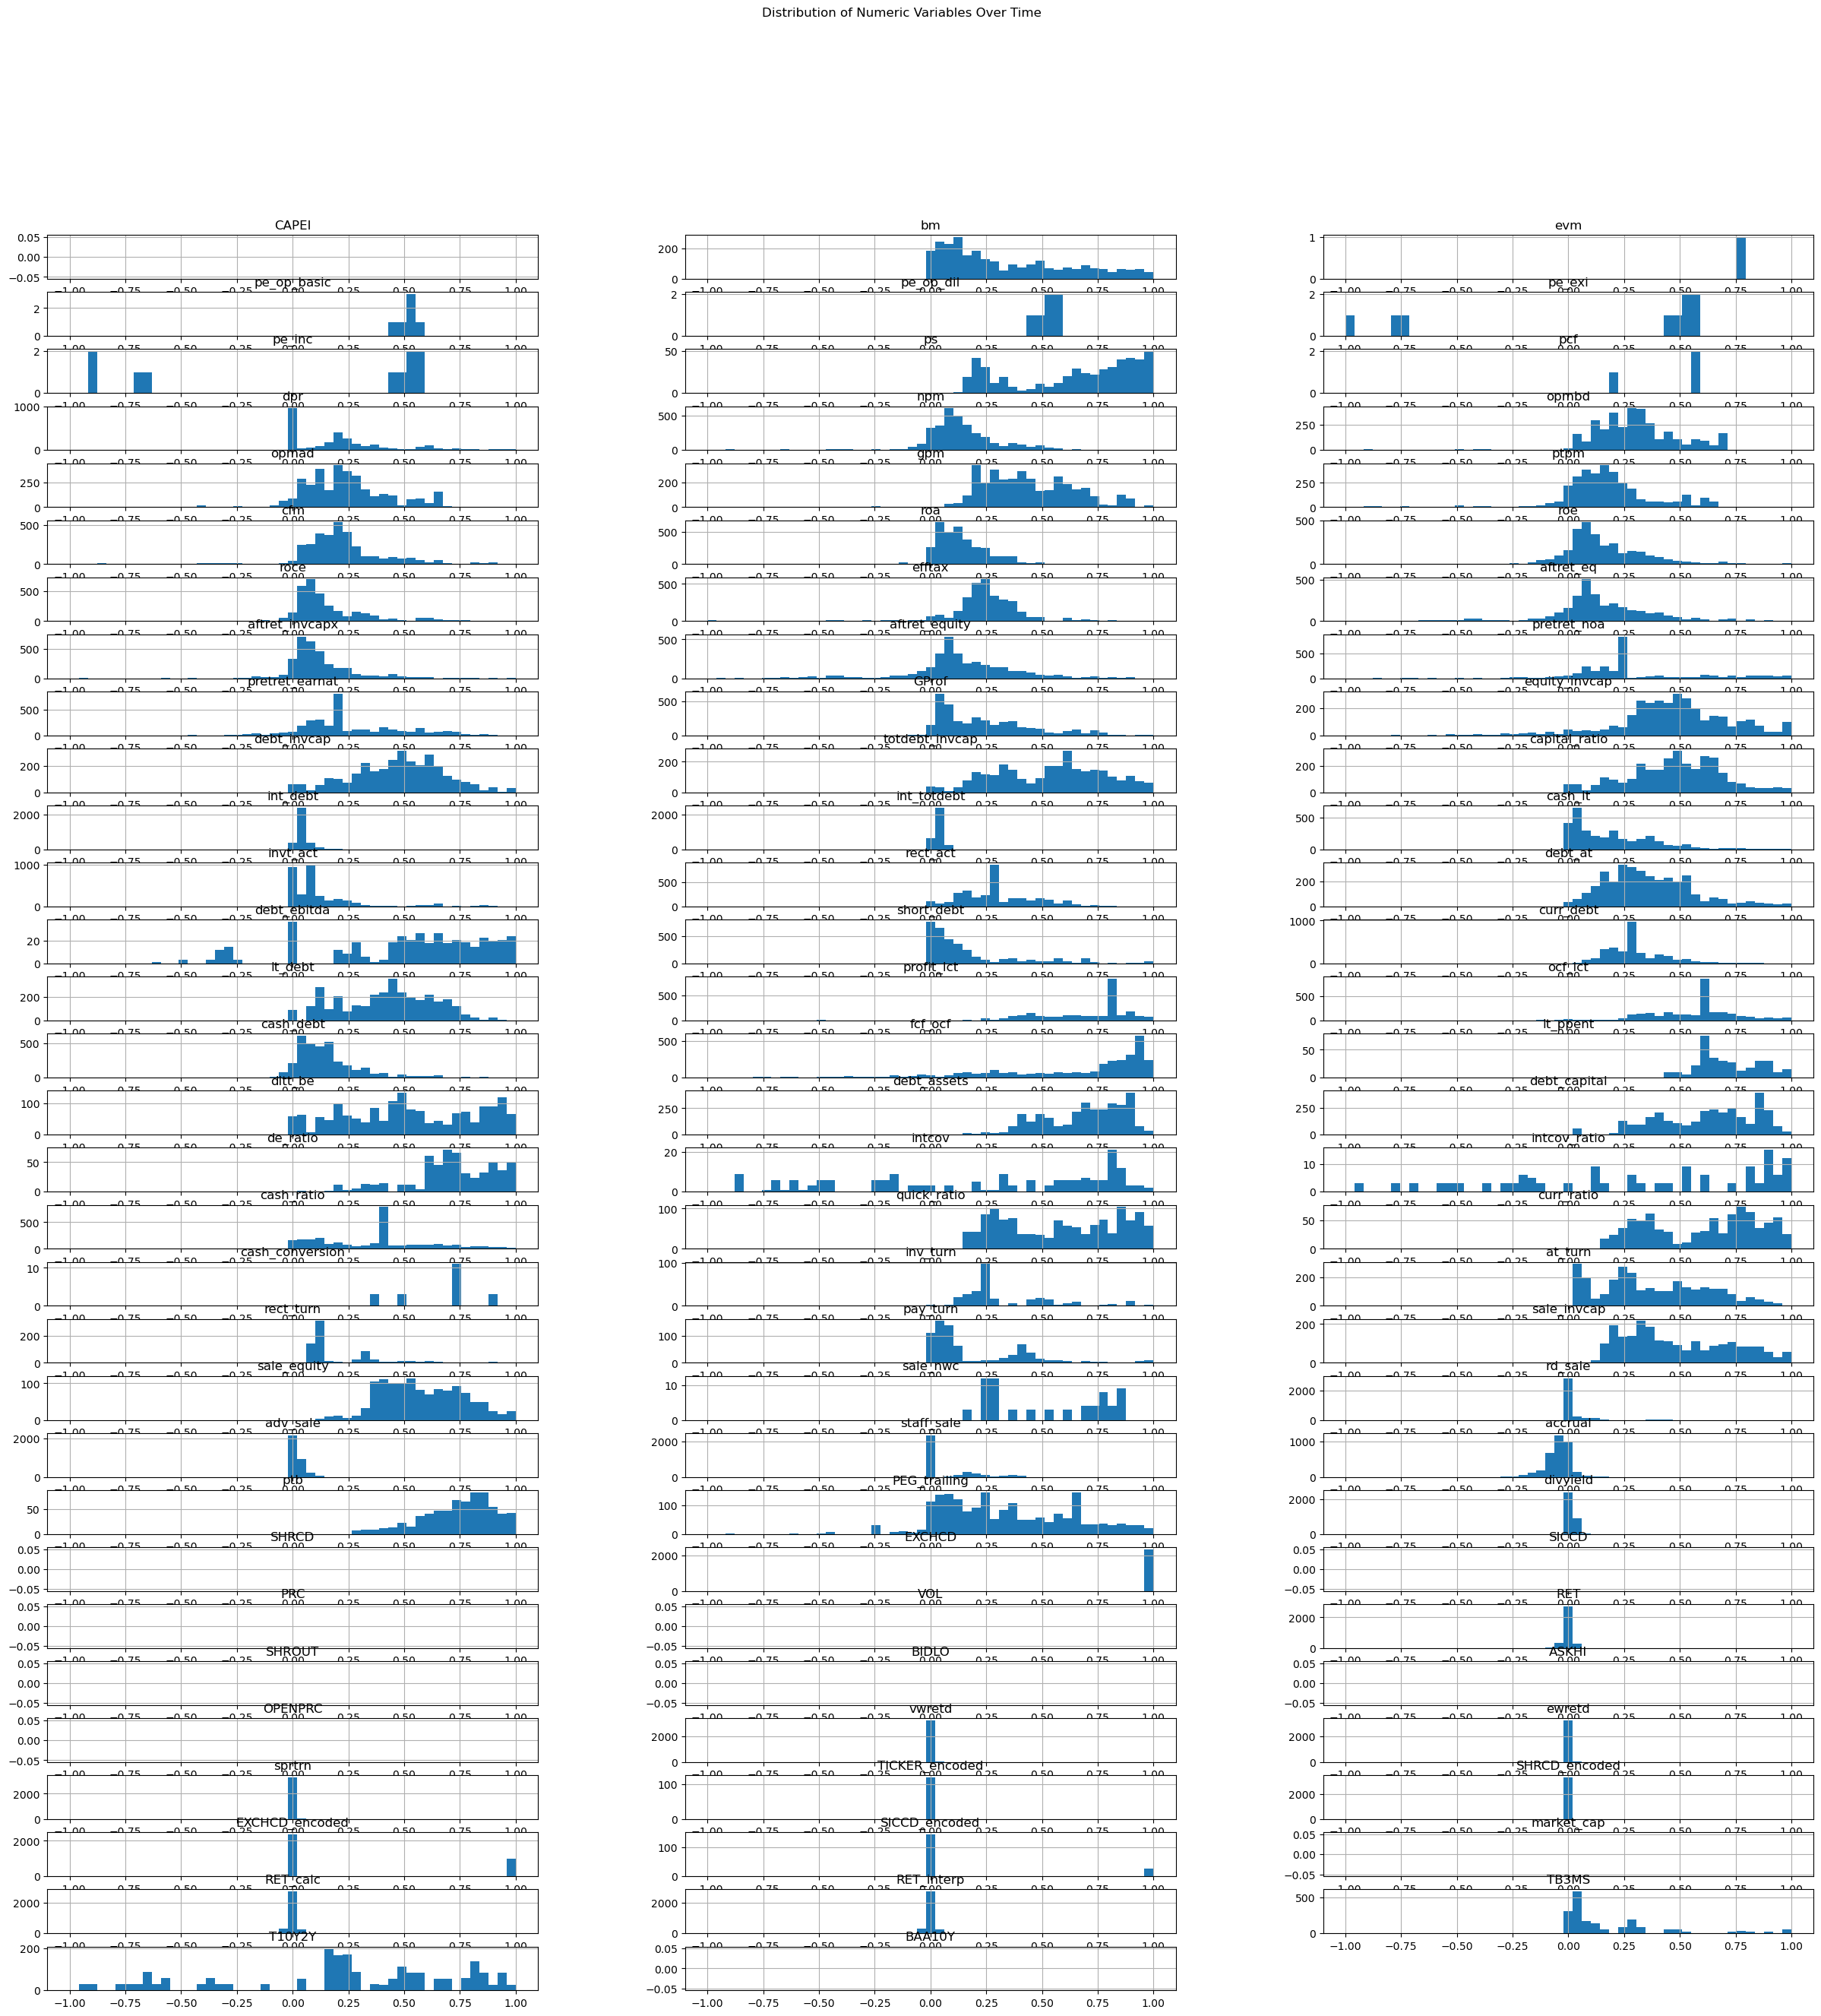

In [40]:
# Filter out non-numeric columns from merged_data
numeric_data = merged_data.select_dtypes(include=[np.number])

# Create a figure and axis object
fig, ax = plt.subplots()

# Set the figure height and width
fig.set_figheight(35)
fig.set_figwidth(30)

# Plot histograms for the numeric columns in numeric_data
numeric_data.hist(layout=(-1, 3), bins=np.linspace(-1,1,50), ax=ax)

# Set the title for the figure
fig.suptitle('Distribution of Numeric Variables Over Time')

# Save the figure as 'numbers_over_time.png'
plt.savefig('Distribution_of_Numeric_Variables_Over_Time.png')

/home/onlyartist9/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


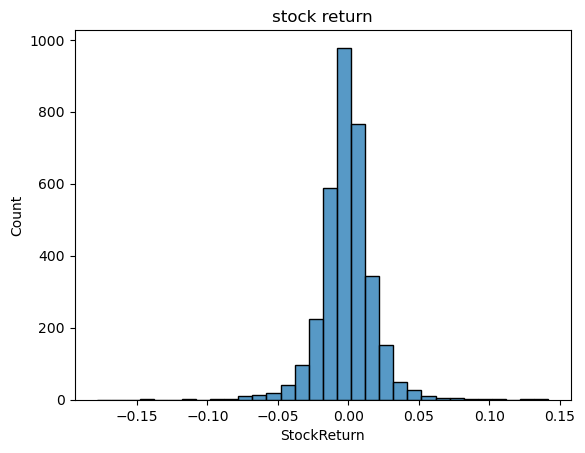

In [43]:
df_3 = merged_data[["RET"]]
df_3 = df_3.rename(columns={'RET': 'StockReturn'})
sns.histplot(data = df_3, x ="StockReturn", binwidth = 0.01, binrange = (df_3["StockReturn"].min()+ 0.00000000001, df_3["StockReturn"].max()- 0.01))
plt.title('stock return')
plt.show()

/home/onlyartist9/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


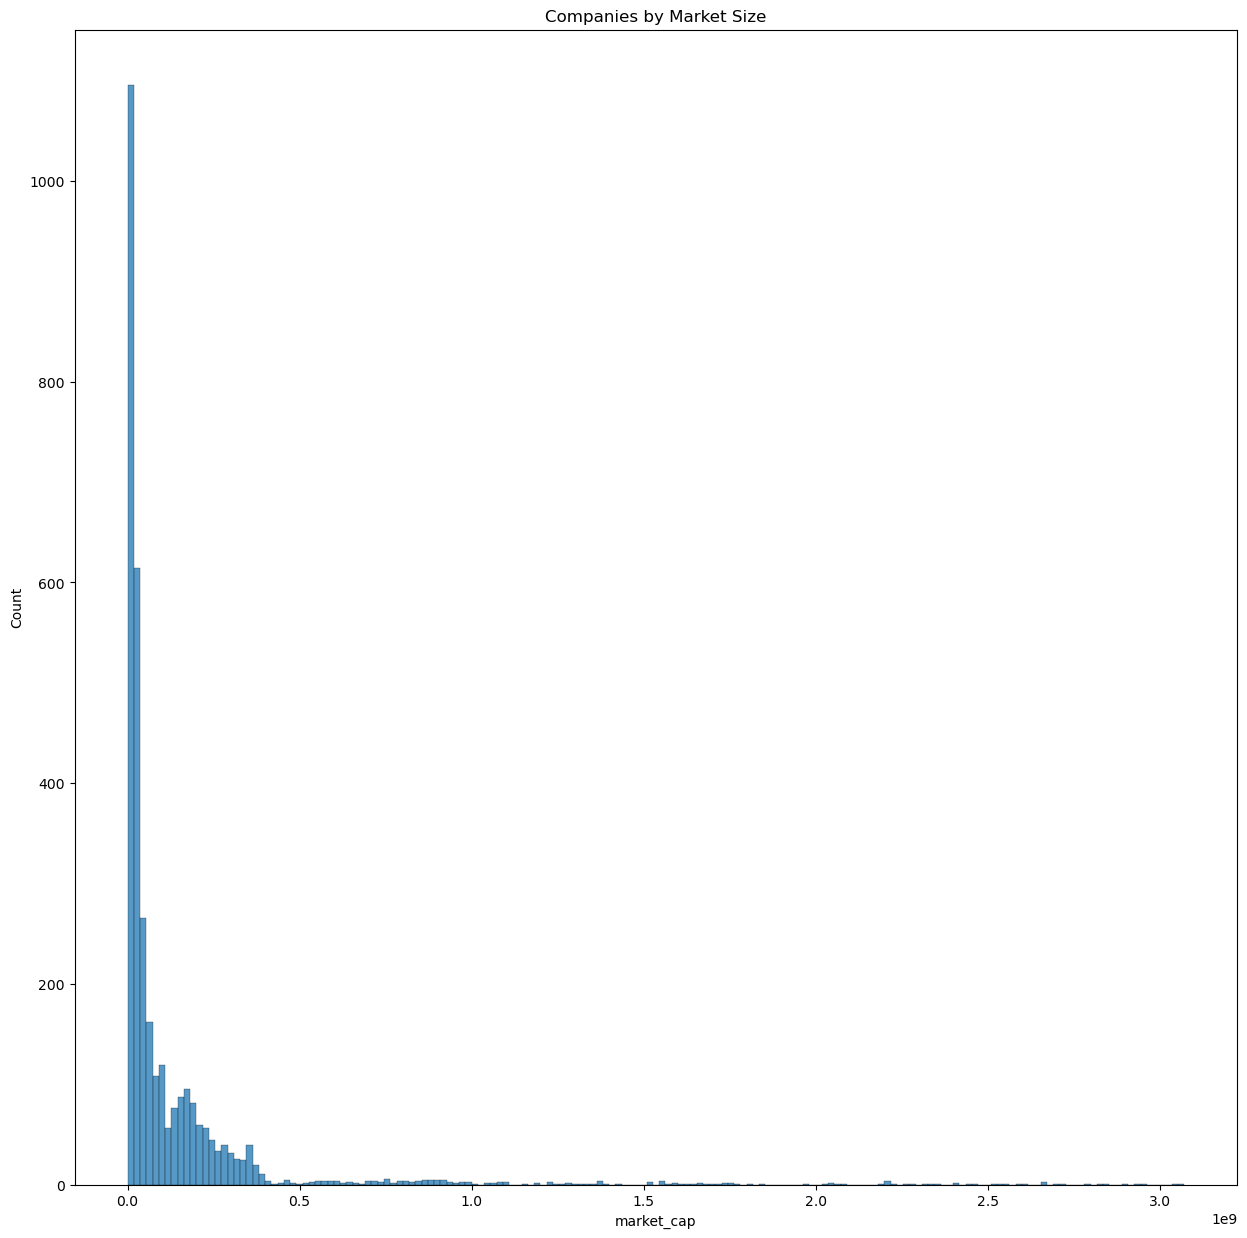

In [47]:
# Set the global size of the figure
fig, ax = plt.subplots()

# Calculate the maximum market capitalization
max_size = merged_data['market_cap'].max()

# Plot the histogram
ax = sns.histplot(data=merged_data, x="market_cap", binrange=(0, max_size))
ax.set_title('Companies by Market Size')  # Set the title

# Define the image size
fig.set_figheight(15)
fig.set_figwidth(15)

# Show the figure
plt.show()

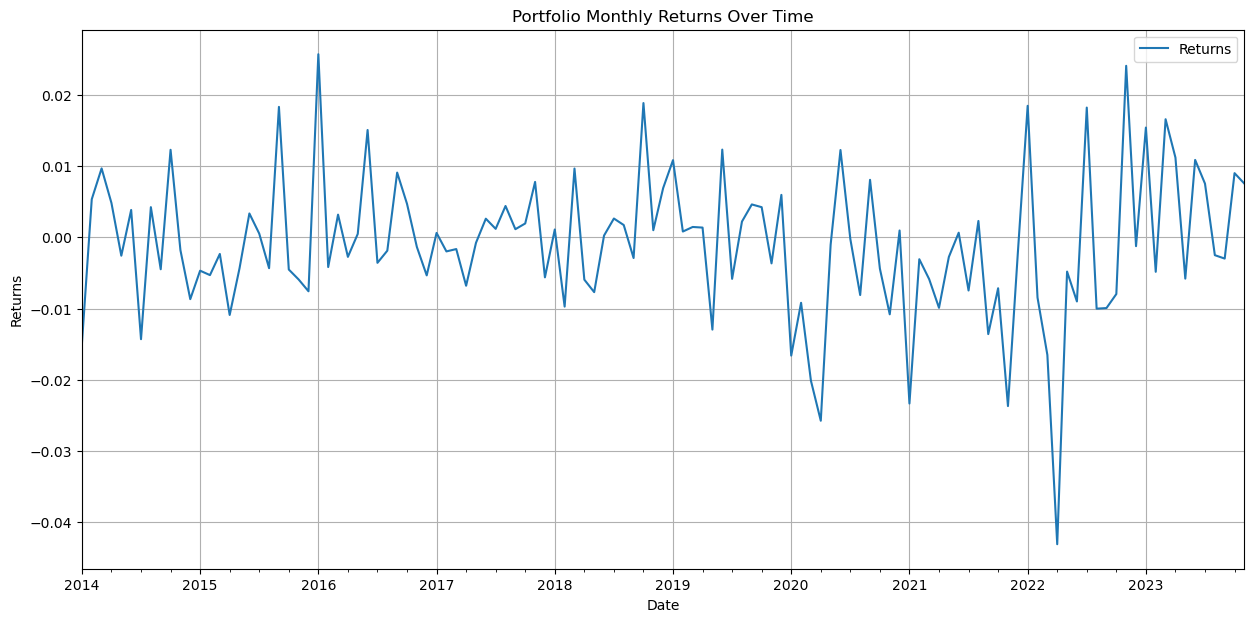

In [48]:
# Assuming final_data is defined
ret_data = merged_data[["RET", "TICKER", "date"]].copy()  # Create a copy to work on to avoid affecting original data

# Create equal weights safely using loc
ret_data['eq_weights'] = 1 / ret_data.groupby('date')['TICKER'].transform('size')

# Calculate monthly return of the equally weighted portfolio containing all stocks
# Use loc to ensure the operation is directly on the DataFrame
ret_data.loc[:, 'return_stock_ew'] = ret_data['RET'].astype(float) * ret_data['eq_weights']

# Calculate the total returns for each date
ret_data.loc[:, 'Returns'] = ret_data.groupby('date')['return_stock_ew'].transform('sum')

# Drop duplicates and set index
unique_ret_data = ret_data[['date', 'Returns']].drop_duplicates().set_index('date')

# Plot the portfolio returns over time
unique_ret_data.plot(grid=True, figsize=(15, 7))
plt.title('Portfolio Monthly Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.grid(True)

# Save the graph
plt.show()

# 5. Feature Engineering

In [49]:
featureEngineeringDf = merged_data.copy()

# Ensure data is sorted by TICKER and date
featureEngineeringDf = featureEngineeringDf.sort_values(['TICKER', 'date'])

featureEngineeringDf.head()

,TICKER,date,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,...,TICKER_encoded,SHRCD_encoded,EXCHCD_encoded,SICCD_encoded,market_cap,RET_calc,RET_interp,TB3MS,T10Y2Y,BAA10Y
0,AAPL,2014-01-31,17.588,0.327,7.993,12.506,12.594,12.594,12.594,2.613,...,0.0,0.0,1.0,10.0,4.465297e+08,0.001637,0.001637,0.04,2.464286,2.334762
1,AAPL,2014-02-28,18.776,0.296,7.764,0.463,0.466,0.466,0.466,2.698,...,0.0,0.0,1.0,10.0,4.694003e+08,-0.002710,-0.002710,0.05,2.382632,2.390000
2,AAPL,2014-03-31,18.501,0.296,7.764,0.472,0.475,0.475,0.475,2.658,...,0.0,0.0,1.0,10.0,4.625330e+08,-0.000224,-0.000224,0.05,2.324286,2.340952
3,AAPL,2014-04-30,20.332,0.296,7.764,0.519,0.523,0.523,0.523,2.921,...,0.0,0.0,1.0,10.0,5.082923e+08,-0.003782,-0.003782,0.03,2.288095,2.199048
4,AAPL,2014-05-31,20.513,0.302,7.873,0.537,0.540,0.540,0.540,3.097,...,0.0,0.0,1.0,10.0,5.452542e+08,-0.003746,-0.003746,0.03,2.170000,2.203810


In [50]:
featureEngineeringDf.columns

Index(['TICKER', 'date', 'CAPEI', 'bm', 'evm', 'pe_op_basic', 'pe_op_dil',
       'pe_exi', 'pe_inc', 'ps', 'pcf', 'dpr', 'npm', 'opmbd', 'opmad', 'gpm',
       'ptpm', 'cfm', 'roa', 'roe', 'roce', 'efftax', 'aftret_eq',
       'aftret_invcapx', 'aftret_equity', 'pretret_noa', 'pretret_earnat',
       'GProf', 'equity_invcap', 'debt_invcap', 'totdebt_invcap',
       'capital_ratio', 'int_debt', 'int_totdebt', 'cash_lt', 'invt_act',
       'rect_act', 'debt_at', 'debt_ebitda', 'short_debt', 'curr_debt',
       'lt_debt', 'profit_lct', 'ocf_lct', 'cash_debt', 'fcf_ocf', 'lt_ppent',
       'dltt_be', 'debt_assets', 'debt_capital', 'de_ratio', 'intcov',
       'intcov_ratio', 'cash_ratio', 'quick_ratio', 'curr_ratio',
       'cash_conversion', 'inv_turn', 'at_turn', 'rect_turn', 'pay_turn',
       'sale_invcap', 'sale_equity', 'sale_nwc', 'rd_sale', 'adv_sale',
       'staff_sale', 'accrual', 'ptb', 'PEG_trailing', 'divyield', 'COMNAM',
       'SHRCD', 'EXCHCD', 'SICCD', 'PRC', 'VOL', 'RET